In [1]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import copy
import matplotlib.pyplot as plt
#from fbprophet.plot import plot_plotly
from prophet.plot import plot_plotly
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from util_prophet import *
#from fbprophet import Prophet
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from prophet.diagnostics import cross_validation

In [2]:
df = pd.read_csv('msft.csv')
df.head()

date  adj_close
0  2000-01-03  36.263777
1  2000-01-04  35.037977
2  2000-01-05  35.408206
3  2000-01-06  34.222851
4  2000-01-07  34.670859

In [3]:
df = df.rename(columns= {'date' : 'ds', 'adj_close': 'y'})

In [4]:
train = pd.read_csv('train_msft.csv')
valid = pd.read_csv('val_msft.csv')

In [6]:
train = train.rename(columns= {'date' : 'ds', 'adj_close': 'y'})
valid = valid.rename(columns= {'date' : 'ds', 'adj_close': 'y'})

In [7]:
model = Prophet()
model.fit(train)

23:55:46 - cmdstanpy - INFO - Chain [1] start processing
23:55:47 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future_data = model.make_future_dataframe(periods=2*12, freq='m')
forecast_data = model.predict(future_data)

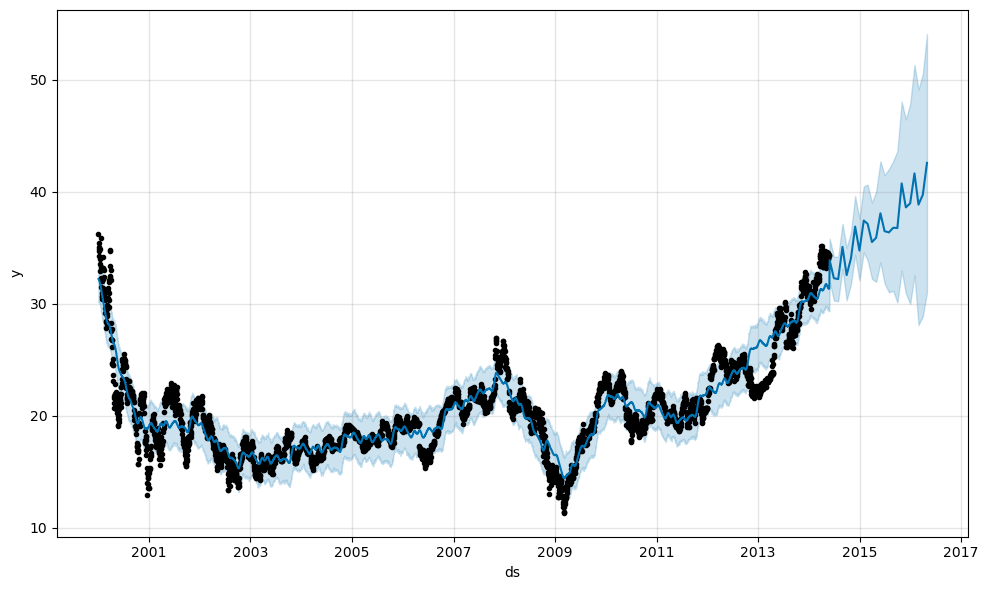

In [9]:
p = model.plot(forecast_data)

black dots are the actual prices, blue line is the forecast. 

In [11]:
plot_plotly_modified(model, forecast_data, valid['ds'], valid['y'])

The red line is the ecent stock price data that extends beyond the historical data used to train the model

<Axes: >

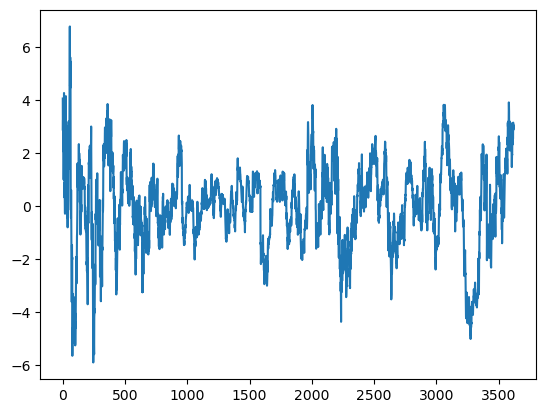

In [13]:
train['resid'] = train['y'] - forecast_data['yhat']
resid_prophet = train['resid']
resid_prophet.plot()

(array([  19.,  117.,  172.,  600., 1260., 1022.,  354.,   70.,    5.,
           3.]),
 array([-5.91215567, -4.64388049, -3.37560532, -2.10733014, -0.83905497,
         0.42922021,  1.69749538,  2.96577055,  4.23404573,  5.5023209 ,
         6.77059608]),
 <BarContainer object of 10 artists>)

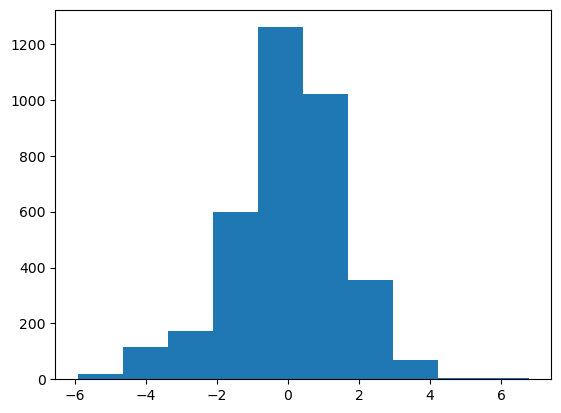

In [14]:
plt.hist(resid_prophet)

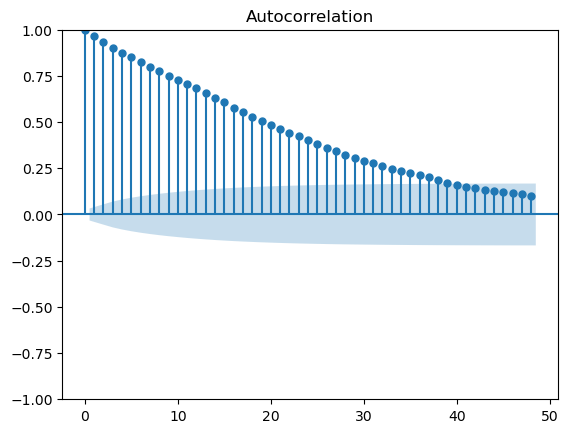

In [15]:
plot_acf(resid_prophet, lags=48)
plt.show()

The presence of high autocorrelation in the residuals suggests that the model might be missing some information. In the context of stock prices, it could be that certain trends or seasonal patterns have not been fully captured by the model.

In [16]:
def error_metrics_prophet(model, train, test):
    # Prepare future dataframe for Prophet to make predictions on test set
    future = pd.DataFrame(test.ds)
    forecast = model.predict(future)
    
    # Extract forecasted values aligning with the test set
    y_pred = forecast['yhat'].values
    
    # Calculating error metrics
    mae = mean_absolute_error(test['y'], y_pred)
    mse = mean_squared_error(test['y'], y_pred)
    mape = mean_absolute_percentage_error(test['y'], y_pred)
    smape = np.mean(2 * np.abs(y_pred - test['y'].values) / (np.abs(test['y'].values) + np.abs(y_pred) + np.finfo(float).eps))

    # Naive forecast using the last observation from training set
    naive_forecast = train['y'].iloc[-1]
    naive_errors = np.abs(train['y'] - naive_forecast).mean()  # Mean absolute error of the naive forecast
    
    # MASE calculation
    mase = mae / naive_errors

    # Compiling metrics into a DataFrame
    df_metrics = pd.DataFrame({
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'sMAPE': [smape],
        'MASE': [mase]
    })

    return df_metrics

In [17]:
error_metrics_prophet(model, train, valid)

MAE         MSE      MAPE     sMAPE      MASE
0  19.882835  697.980864  0.266976  0.326631  1.445367

# CV and Hyperparams tuning 

In [19]:
cutoffs = pd.date_range(start='2001-01-01', end='2013-01-01', freq='AS')
df_cv = cross_validation(model, cutoffs=cutoffs, horizon='365 days')
#df_cv = cross_validation(model, initial='730 days', period='1825 days', horizon = '365 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/13 [00:00<?, ?it/s]

23:59:34 - cmdstanpy - INFO - Chain [1] start processing
23:59:34 - cmdstanpy - INFO - Chain [1] done processing
23:59:35 - cmdstanpy - INFO - Chain [1] start processing
23:59:36 - cmdstanpy - INFO - Chain [1] done processing
23:59:36 - cmdstanpy - INFO - Chain [1] start processing
23:59:37 - cmdstanpy - INFO - Chain [1] done processing
23:59:37 - cmdstanpy - INFO - Chain [1] start processing
23:59:38 - cmdstanpy - INFO - Chain [1] done processing
23:59:38 - cmdstanpy - INFO - Chain [1] start processing
23:59:38 - cmdstanpy - INFO - Chain [1] done processing
23:59:39 - cmdstanpy - INFO - Chain [1] start processing
23:59:39 - cmdstanpy - INFO - Chain [1] done processing
23:59:40 - cmdstanpy - INFO - Chain [1] start processing
23:59:40 - cmdstanpy - INFO - Chain [1] done processing
23:59:41 - cmdstanpy - INFO - Chain [1] start processing
23:59:41 - cmdstanpy - INFO - Chain [1] done processing
23:59:41 - cmdstanpy - INFO - Chain [1] start processing
23:59:42 - cmdstanpy - INFO - Chain [1]

In [20]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  11.089829  3.330139  2.318148  0.122132  0.074806  0.128792   
1 38 days  11.512591  3.393021  2.369791  0.124518  0.077770  0.131746   
2 39 days  11.805925  3.435975  2.402289  0.126408  0.077770  0.134058   
3 40 days  11.831847  3.439745  2.407960  0.126933  0.077770  0.134489   
4 41 days  11.871465  3.445499  2.424692  0.127927  0.079105  0.135308   

   coverage  
0  0.537686  
1  0.531902  
2  0.530675  
3  0.530675  
4  0.526840

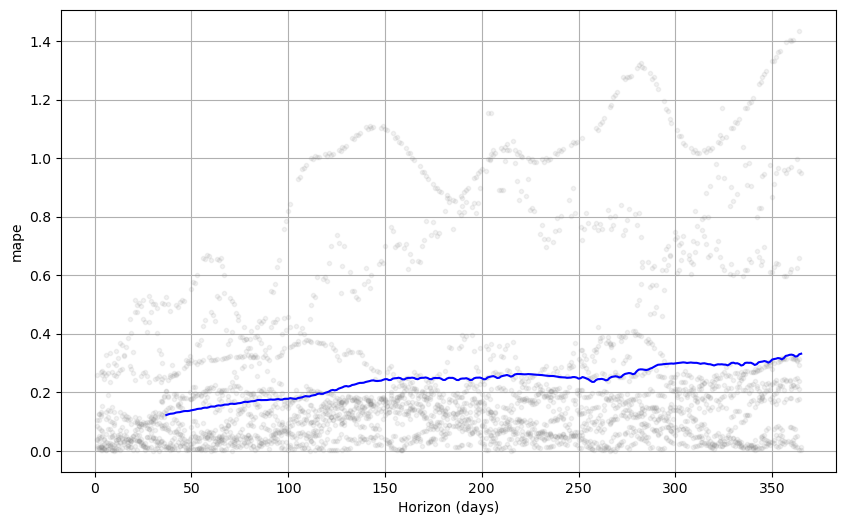

In [21]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The blue line suggests that as the horizon increases, the MAPE also generally increases, though not linearly. This indicates that longer horizons tend to increase the uncertainty and difficulty of making accurate predictions. The line remains relatively low, suggesting that the average error as a percentage of actual values is quite reasonable across the board, although it starts to pick up slightly as the horizon extends past 300 days. 
There are visible spikes where the MAPE increases sharply before dropping back. This could indicate specific periods where the model struggled more than usual, possibly due to unmodeled shocks or seasonal effects that the model did not capture accurately

In [22]:
import itertools


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:00:09 - cmdstanpy - INFO - Chain [1] start processing
00:00:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:01:01 - cmdstanpy - INFO - Chain [1] start processing
00:01:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  3.478445
1                     0.001                     0.10  3.488781
2                     0.001                     1.00  3.489909
3                     0.001                    10.00  3.500486
4                     0.010                     0.01  2.955912
5                     0.010                     0.10  3.380245
6                     0.010                     1.00  3.396676
7                     0.010                    10.00  3.385822
8                     0.100                     0.01  2.776436
9                     0.100                     0.10  3.261931
10                    0.100                     1.00  3.246359
11                    0.100                    10.00  3.308115
12                    0.500                     0.01  2.767449
13                    0.500                     0.10  3.977684
14                    0.500                     1.00  3

 - **changepoint_prior_scale** - This is the most impactful parameter. It determines how much the trend changes at the changepoints, the flexibility of the trend. If this value is too small, the trend will be underfit and if it is too large, the trend will be overfit. Suggested tuning range [0.001, 0.5]<br>
 
 
 - **seasonality_prior_scale** - controls the flexibility of the seasonality. A large value allows the seasonality to fit large fluctuation, a small value shrinks the magnitude of the seasonality. Default is 10, which is no regularization. Suggested tuning range [0.01,10]

In [23]:
modeltuned = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)
modeltuned.fit(train)
future_data = modeltuned.make_future_dataframe(periods=2*12, freq='m')
forecast_data = modeltuned.predict(future_data)

00:06:21 - cmdstanpy - INFO - Chain [1] start processing
00:06:21 - cmdstanpy - INFO - Chain [1] done processing


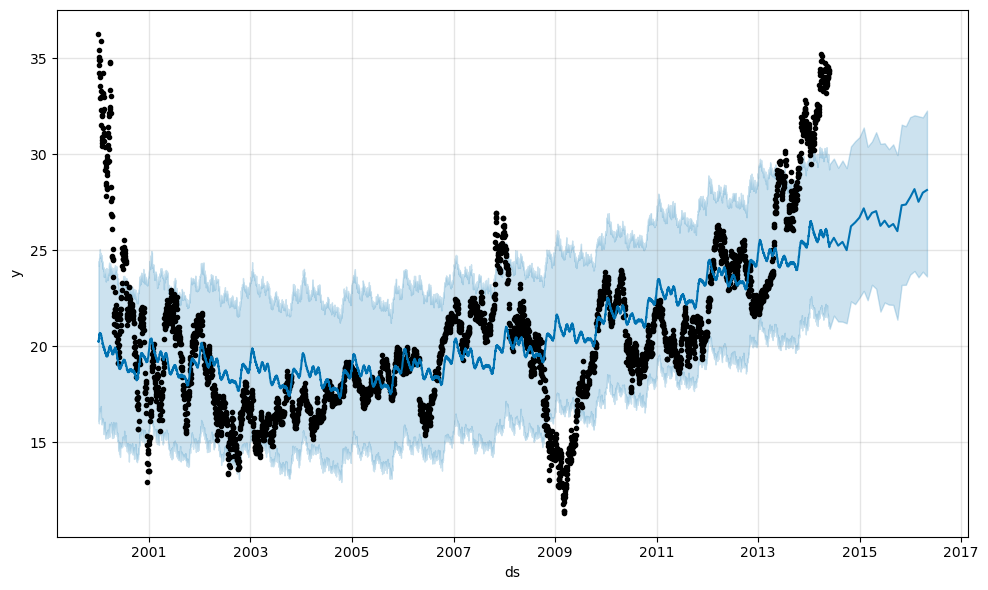

In [24]:
p = modeltuned.plot(forecast_data)
plt.show()

In [25]:
modeltuned2 = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10)
modeltuned2.fit(train)
future_data2 = modeltuned2.make_future_dataframe(periods=2*12, freq='m')
forecast_data2 = modeltuned2.predict(future_data2)

00:06:34 - cmdstanpy - INFO - Chain [1] start processing
00:06:36 - cmdstanpy - INFO - Chain [1] done processing


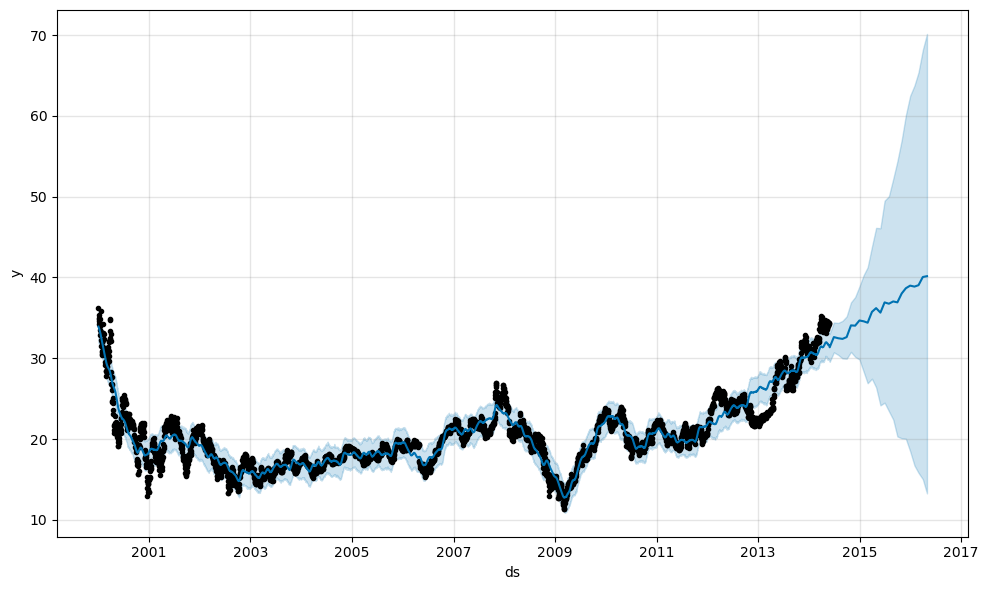

In [26]:
p = modeltuned2.plot(forecast_data2)
plt.show()

In [27]:
error_metrics_prophet(modeltuned, train, valid)

MAE          MSE      MAPE     sMAPE     MASE
0  33.756884  1602.332872  0.495275  0.683041  2.45393

In [28]:
error_metrics_prophet(modeltuned2, train, valid)

MAE         MSE      MAPE     sMAPE      MASE
0  19.566307  682.169615  0.261782  0.319636  1.422357